Possible Required Installs. Run the cell below if you run into any complications (Should take ~15 seconds):

In [1]:
%pip install pandas numpy scikit-learn matplotlib
%pip install kaggle
%pip install numpy
%pip install pandas
%pip install pandas numpy scikit-learn
%pip install pandas numpy scikit-learn matplotlib kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



Required imports:

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  ## I did this to get rid of the "copy of slice" df warning
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

Load and prepare data (Run if you have enough available memory)

In [3]:
## Load csv
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)

## Data prep
def prepare_data(df):
    ## Filter null revenue/budget vals
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df = df[(df['revenue'] > 0) & (df['budget'] > 0)]
    
    ## Log-transform popularity since large under calculations (budet too)
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
    df['popularity'] = np.clip(df['popularity'].fillna(0), 1, 100)
    df['log_popularity'] = np.log1p(df['popularity'])
    
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
    df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
    
    ## Convert genres to binary
    genres = ['Action', 'Comedy', 'Drama', 'Adventure']
    for genre in genres:
        df[f'genre_{genre}'] = df['genres'].str.contains(genre, case=False).astype(int)
    
    ## Log-transform target and budget (Since they are large vals)
    df['log_revenue'] = np.log1p(df['revenue'])
    df['log_budget'] = np.log1p(df['budget'])
    
    return df.dropna(subset=['log_revenue', 'log_budget', 'log_popularity', 'vote_count', 'release_year'])

Feature Selection and Training

In [4]:
movies_clean = prepare_data(movies_df)

## Feature Selection (Can add more if needed later)
numeric_features = ['log_budget', 'log_popularity', 'vote_count', 'release_year']
categorical_features = ['genre_Action', 'genre_Comedy', 'genre_Drama', 'genre_Adventure']
target = 'log_revenue'

## Train-Test Split
X = movies_clean[numeric_features + categorical_features]
y = movies_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipeline w/ OneHot for categorical vars
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## Final model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

## Train model w/ Linear Regression
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_budget',
                                                   'log_popularity',
                                                   'vote_count',
                                                   'release_year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre_Action',
                                                   'genre_Comedy',
                                                   'genre_Drama',
                                                   'genre_Adventure'])])),
                ('regressor', LinearRegression())])

Visualization and stats of actual vs predicted revenues (On base 10 log scale)

Log scale statistics: 
R² Score: 0.586
RMSE: 1.669
Mean Absolute Error: 1.136
Mean Average Precision Error: 0.099


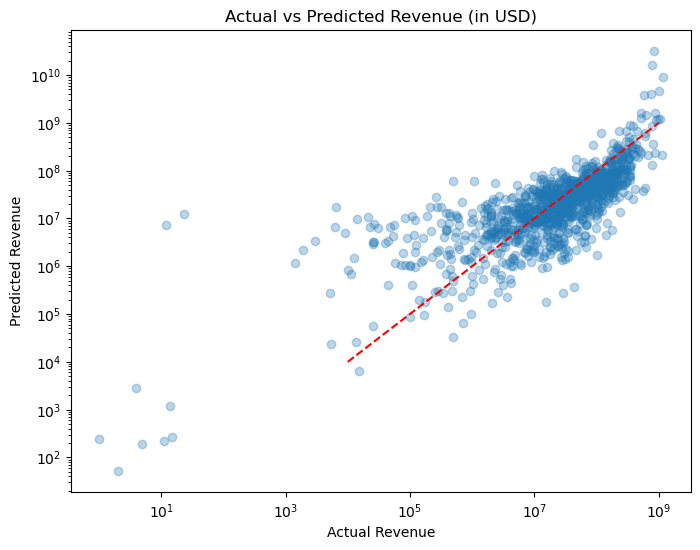

In [10]:
## Stats
y_pred = model.predict(X_test)
print("Log scale statistics: ")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"Mean Absolute Error: {(1 / len(y_test)) * np.sum(np.abs(y_test - y_pred)):.3f}")
print(f"Mean Average Precision Error: {(np.fabs(y_test - y_pred)/y_test)[y_test!=0].mean():.3f}")

## Can't use dollar amounts since budget and revenue were log-transformed I think?

## Actual vs pred plot (w/ log 10 scale)
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.3)
plt.plot([1e4, 1e9], [1e4, 1e9], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue (in USD)')
plt.savefig('../_layouts/actual_vs_predicted_revenue.jpg') ## Saves to _layouts
plt.show()

Visualize the effect of budget on revenue

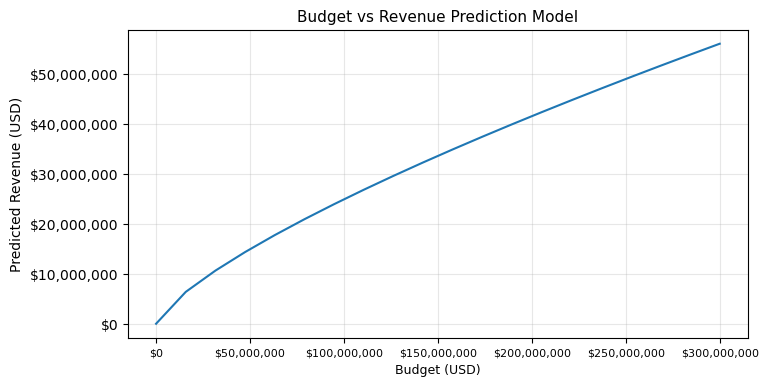

In [ ]:
def test_budget_effect(model):
    test_data = X_train.iloc[:1].copy()
    revenues = []
    budgets = np.linspace(1, 3e8, 20) ## Ranges 1 to 300 mil
    
    for budget in budgets:
        test_data['log_budget'] = np.log1p(budget)
        pred = model.predict(test_data)
        revenues.append(np.expm1(pred[0]))
    
    plt.figure(figsize=(8, 4))
    plt.plot(budgets, revenues)
    plt.xlabel('Budget (USD)', fontsize=9)
    plt.ylabel('Predicted Revenue (USD)', fontsize=10)
    plt.title('Budget vs Revenue Prediction Model', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.grid(True)
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter('${x:,.0f}')
    ax.xaxis.set_major_formatter('${x:,.0f}')
    ax.tick_params(axis='x', labelsize=8)

    plt.savefig('../_layouts/budget_vs_revenue_prediction.jpg') ## Saves to _layouts
    plt.show()

test_budget_effect(model)

Calculates linear regression coefficients

C:\Users\gemc\AppData\Local\Temp\ipykernel_20188\2140799994.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


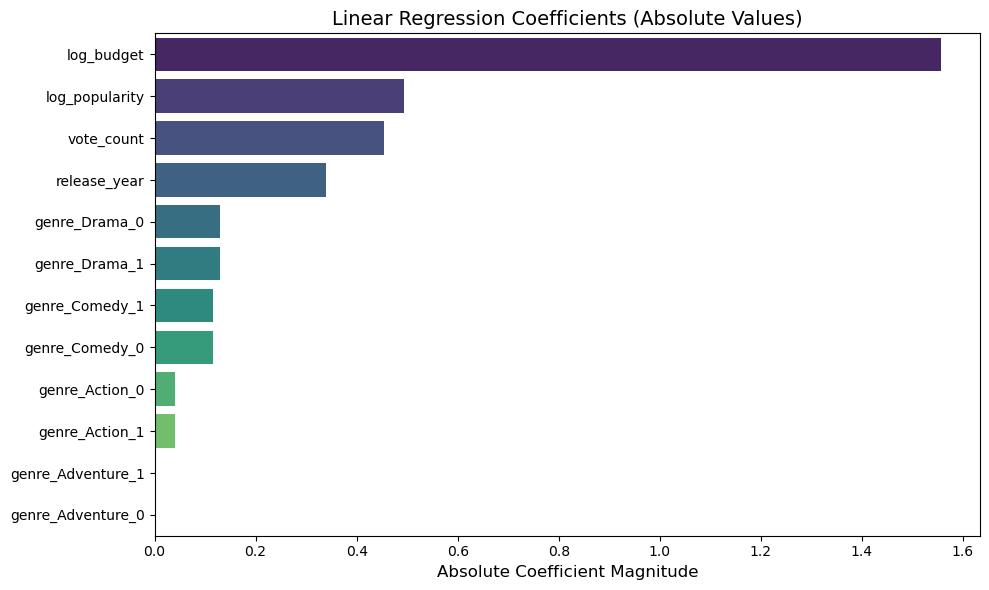

In [21]:
def plot_linear_regression_coefficients(pipeline):
    ## Get model
    model = pipeline.named_steps['regressor']
    preprocessor = pipeline.named_steps['preprocessor']
    
    ## Get features
    numeric_features = preprocessor.named_transformers_['num'].feature_names_in_
    ohe = preprocessor.named_transformers_['cat']
    categorical_features = ohe.get_feature_names_out(
        input_features=preprocessor.feature_names_in_[len(numeric_features):]
    )
    feature_names = list(numeric_features) + list(categorical_features)
    
    ## Take coefficients from df as absolute values
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    ## Make plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Abs_Coefficient', 
        y='Feature',
        legend=False,
        data=coef_df,
        palette='viridis'
    )
    plt.title('Linear Regression Coefficients (Absolute Values)', fontsize=14)
    plt.xlabel('Absolute Coefficient Magnitude', fontsize=12)
    plt.ylabel('')
    plt.tight_layout()
    
    return coef_df

coef_df = plot_linear_regression_coefficients(model)
plt.savefig('../_layouts/regression_coefficients.jpg') ## Saves to _layouts
plt.show()

Prediction Function

In [ ]:
def predict_movie_revenue(budget, popularity, vote_count=movies_df['vote_count'].mean(skipna=True), release_year=2000, 
                         is_action=False, is_comedy=False, is_drama=False, is_adventure=False):
    
    input_data = pd.DataFrame({
        'log_budget': [np.log1p(budget)],
        'log_popularity': [np.log1p(np.clip(popularity, 1, 100))],
        'vote_count': [vote_count],
        'release_year': [release_year],
        'genre_Action': [int(is_action)],
        'genre_Comedy': [int(is_comedy)],
        'genre_Drama': [int(is_drama)],
        'genre_Adventure': [int(is_adventure)]
    })
    
    ## Calculate pred in log form then convert back
    log_pred = model.predict(input_data)[0]
    return vote_count == movies_df['vote_count'].mean(skipna=True), np.expm1(log_pred)

$\textbf{Call the prediction function below:}$

In [ ]:
## Test here! Given the dataset we chose, use movies from within this range: 12/08/1874 - 12/15/2020
## Future reference: Outlier movies (Such as Avengers: Endgame, other extreme successes) will likely be off.
## Uncomment vote_count if available.
avg_vc_used, predicted_revenue = predict_movie_revenue( ## Avengers Endgame (outlier) example rn
    budget=356000000,
    popularity=100, ## Range is [0, 100]
    #vote_count=4900,
    release_year=2019, ## Earliest: 1874
    is_action=True,
)

print(f"Unless specified, the average TMDb vote_count ({movies_df['vote_count'].mean(skipna=True):,.2f}) will be used.")
print(f"Average vote_count used: {avg_vc_used}")
print(f"Predicted Revenue: ${predicted_revenue:,.2f}")

Unless specified, the average TMDb vote_count (109.90) will be used.
Average vote_count used: True
Predicted Revenue: $801,727,439.42
